# Visualising a geometry

When building a geometry, it is of the utmost importance to verify it has been correctly defined by making a plot of the geometry. To do so, `TRIPOLI-5` embeds a plotting system that relies on the actual navigators used in the particle tracking for the AGORA and ROOT geometries. This allows us to plot the geometry exactly as particles will see it.

## Prerequisites: Imports and geometry definition

To illustrate the plotting functionnality, we will use the assembly defined in the [AGORA](mixtures.ipynb) geometry notebook. 

In [1]:
%load_ext wurlitzer

In [2]:
import tripoli5
from tripoli5.core.euclide import Direction, Point, Vector

# Define two concentric cylinders with labels
s1 = tripoli5.agora.ZCylinder(0.0, 0.0, 0.55, label="inner_cylinder")
s2 = tripoli5.agora.ZCylinder(0.0, 0.0, 0.85, label="outer_cylinder")

# Create shapes using the cylinders
sh1 = tripoli5.agora.Shape(-s1)  # Inner cylinder
sh2 = tripoli5.agora.Shape(+s1 & -s2)  # Shell between s1 and s2
sh3 = tripoli5.agora.Shape(+s2)  # Outer cylinder

# Create volumes from the shapes and material names
v1 = tripoli5.agora.Volume(sh1, "FUEL", label="inner_fuel")
v2 = tripoli5.agora.Volume(sh2, "CLADDING", label="cladding_shell")
v3 = tripoli5.agora.Volume(sh3, "WATER", label="outer_water")

# Create a universe with a list of volumes
u1 = tripoli5.agora.Universe([v1, v2, v3], label="fuel_universe")

# Define the lower-left corner of the lattice
lower_left = Point(-10.0, -10.0, -10.0)

# Define the pitch vector for the lattice
pitch = Vector(2.0, 2.0, 2.0)

# Create an infinite background universe filled with concrete
background_universe = tripoli5.agora.createInfinite(material="WATER_HOT")

# Create a rectangular lattice
lattice = tripoli5.agora.RectLattice(
    point=lower_left,
    pitch=pitch,
    nx=10,
    ny=10,
    nz=0,
    universe=u1,
    outer_universe=background_universe,  # Optional
    label="lattice_base_10x10",  # Optional
)

# Define another universe
sh11 = tripoli5.agora.Shape(-s2)
sh12 = tripoli5.agora.Shape(+s2)

# Create volumes from the shapes and assign materials
v11 = tripoli5.agora.Volume(sh11, "UOX", label="uox_volume")
v12 = tripoli5.agora.Volume(sh12, "STEEL", label="steel_volume")

# Create a universe with the defined volumes
u3 = tripoli5.agora.Universe([v11, v12], label="uox_steel_universe")
u4 = tripoli5.agora.createInfinite(material="LEAD")

# Set lattice cells to the new universe
lattice[1, 4, 0] = u3
lattice[8, 7, 0] = u3
lattice[8, 1, 0] = u3
lattice[5, 4, 0] = u4
lattice[3, 8, 0] = u4

# Define a box to delimit the lattice
cyl = tripoli5.agora.ZCylinder(0.0, 0.0, 15.0)

lattice_volume = tripoli5.agora.CompositeVolume(
    shape=tripoli5.agora.Shape(-cyl), filler=lattice
)
concrete_volume = tripoli5.agora.Volume(
    shape=tripoli5.agora.Shape(+cyl), material="CONCRETE"
)
root_universe = tripoli5.agora.Universe([lattice_volume, concrete_volume])
# Create a geometry with the root universe
geometry = tripoli5.agora.Geometry(root_universe=root_universe)

## Creating the plotter engine

First of all, the plotter engine is instantiated by providing the geometry to plot. 

In [3]:
plotter = tripoli5.geoplotter.GeoPlotterPyplot(geometry)

## Defining a frame

Frames define the actual window which will be used for plotting the figure.  
A frame is defined by 
1. A cut plane; currently only cuts perpendicular to the x-, y- and z-axes are possible
2. An altitude, or the coordinate of the plane along the cut axis
3. Boundaries of the plot in cut-plane along the two remaining axes

Cut planes are defined as a python string: "XY" for a z-cut, "XZ" for a y-cut and "YZ" for an x-cut.  
Boundaries can be defined by providing either the minimum and maximum values of the two remaining coordinates of the frame window in that plane or by providing an origin (a Point and its position on the graph) and an extent in each direction. Note, however, that when using the "extent" version the altitude is retrieved from the point of origin definition.

Examples are provided below with the alternate definitions. 

In [4]:
# A frame defining a z-cut at z=0 with boudnaries x in [-18, 18] and y in [-18, 18]
frame_minmax = tripoli5.geoplotter.Frame.fromMinMax(
    "XY", altitude=0, u_min=-18, u_max=18, v_min=-18, v_max=18
)

# The same frame defined using the extent version
frame_origin = tripoli5.geoplotter.Frame.fromOrigin(
    "XY",
    point=Point(0.0, 0.0, 0.0),
    origin="center",  # accepted values can be found with help(tripoli5.geoplotter.Frame.fromOrigin)
    extent=[36.0, 36.0],
)

## Plotting the geometry: TL;DR

Then, one may plot the geometry using the engine's function `plot` with the frame as an argument.  
Eventually, one may save this figure to a file ***with extension*** for future use. 

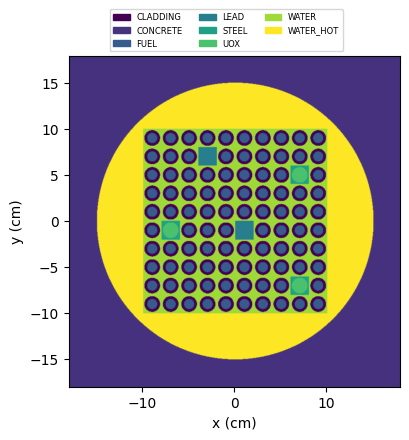

In [5]:
_ = plotter.plot(frame=frame_minmax, save_to_file="my_lattice.png")

## Plotting the geometry: full options

The plotter has various options that allows modifying its behavior, from how the plot is built (interrogating points or ray-tracing) to the colors used.  

First it should be noted that the plotter actually relies on matplotlib's [`imshow`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html).  
The plotter generates a 2D-array of pixels which is passed to `imshow`.  

The plot function actually returns a [`pyplot.axe.Axes`](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.html) and a list of [`matplotlib.patches.Patch`](https://matplotlib.org/stable/api/_as_gen/matplotlib.patches.Patch) which is useful for defining the legend of the plot. 

Let's go through the most useful options of the `plot` function.  
We recall that the entire API is printable using `help(plotter.plot)`.  

### Saving to a file

The option `save_to_file` allows defining a file (must be provided with extension, e.g. '.png') to which the plot will be saved. 

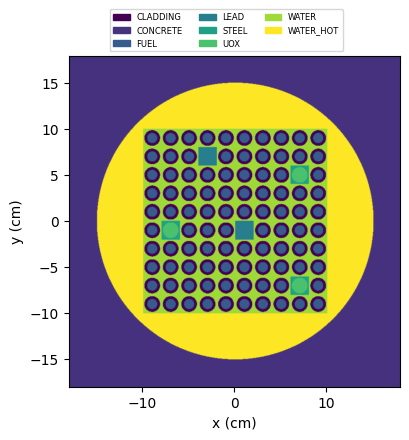

In [6]:
ax, patches = plotter.plot(frame=frame_minmax, save_to_file="my_lattice.png")

### Changing the resolution

The resolution is defined as the number of pixel per cm for interrogating the geometry. This value is used in both the $u$ and $v$ directions. 

Note that if this value is too low compared to the size of the image, pixelization will appear, while if it is too high compared to the size of the image, it will interrogate numerous points and may lead to long times to generate the plot. For information, it appears that most of the computing time is not actually spent interrogating the geometry but rather in reconstructing the 2D numpy array.

Let's observe the pixelization with various resolutions.  
It should be noted that `imshow` somehow interpolates the picture to reconstruct an image with the proper size. 

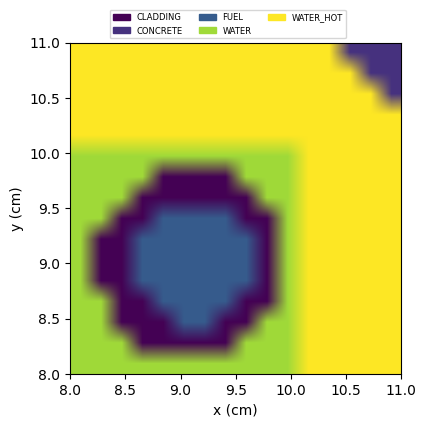

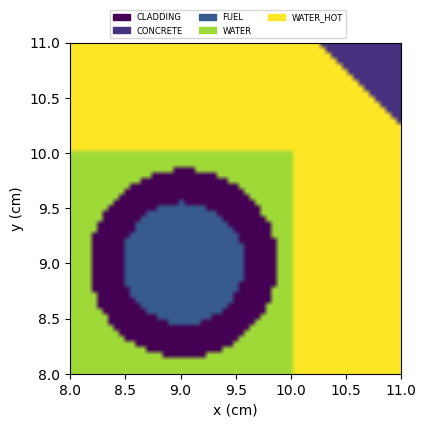

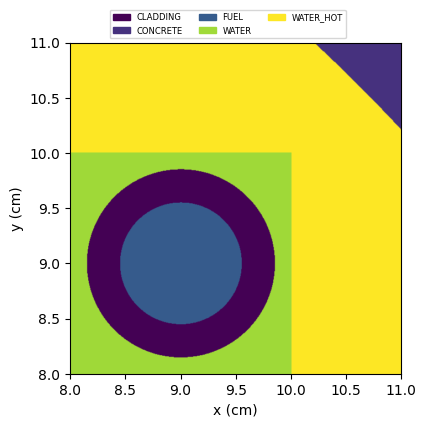

In [7]:
frame_resolution = tripoli5.geoplotter.Frame.fromMinMax(
    "XY", altitude=0, u_min=8, u_max=11, v_min=8, v_max=11
)
ax, patches = plotter.plot(frame=frame_resolution, resolution=5)
ax, patches = plotter.plot(frame=frame_resolution, resolution=20)
ax, patches = plotter.plot(frame=frame_resolution, resolution=200)

### Passing a matplotlib Axes

As the plotter uses matplotlib's backend, we accept an optional [`pyplot.axe.Axes`](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.html) argument, allowing the user to build their own figure using matplotlib's usual options. 
In this case, the plotter will fill in the Axes. 

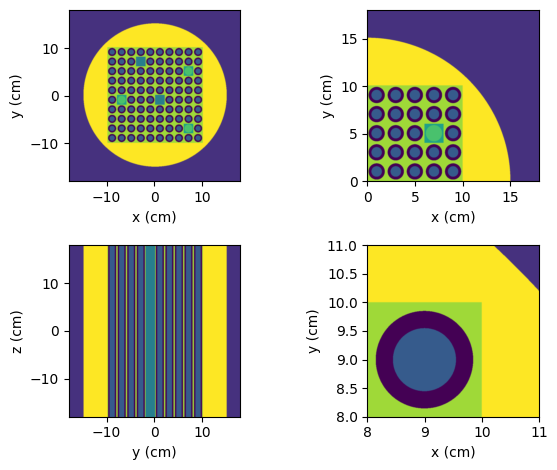

In [8]:
frame_1 = tripoli5.geoplotter.Frame.fromMinMax(
    "XY", altitude=0, u_min=-18, u_max=18, v_min=-18, v_max=18
)
frame_2 = tripoli5.geoplotter.Frame.fromMinMax(
    "YZ", altitude=1, u_min=-18, u_max=18, v_min=-18, v_max=18
)
frame_3 = tripoli5.geoplotter.Frame.fromMinMax(
    "XY", altitude=0, u_min=0, u_max=18, v_min=0, v_max=18
)
frame_4 = tripoli5.geoplotter.Frame.fromMinMax(
    "XY", altitude=0, u_min=8, u_max=11, v_min=8, v_max=11
)
import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows=2, ncols=2)
_ = plotter.plot(frame=frame_1, resolution=20, ax=axs[0][0])
_ = plotter.plot(frame=frame_2, resolution=20, ax=axs[1][0])
_ = plotter.plot(frame=frame_3, resolution=50, ax=axs[0][1])
_ = plotter.plot(frame=frame_4, resolution=200, ax=axs[1][1])
plt.tight_layout()

Another example is the legend handling. With the default `ax` option (`None`) the legend is placed above the plot. However, one may desire to have no legend or position the legend at some other location. To that end, the `plot` function returns a list of `matplotlib.patches.Patch` that can then be provided as `handles` in the [`legend`](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.legend.html) function.

Below are two examples: one plot without a legend, and another with a legend located on the right.

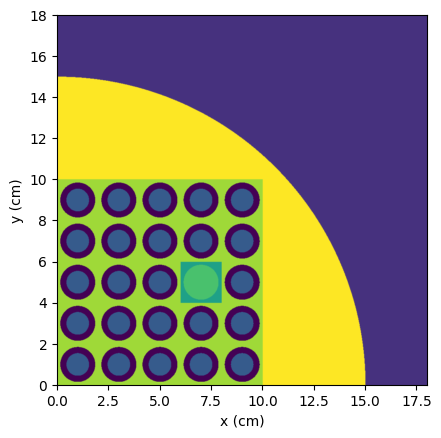

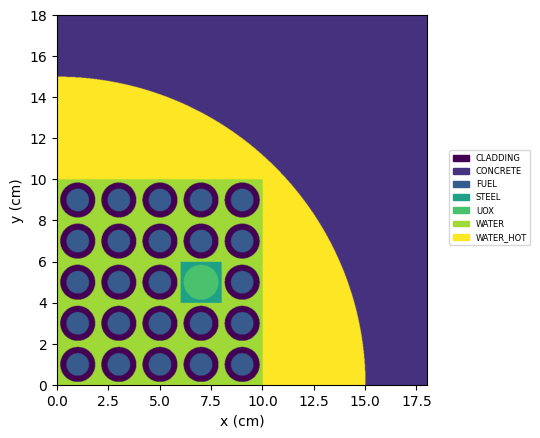

In [9]:
frame = tripoli5.geoplotter.Frame.fromMinMax(
    "XY", altitude=0, u_min=0, u_max=18, v_min=0, v_max=18
)

# no legends
fig, axs = plt.subplots()
_, patches = plotter.plot(frame=frame, ax=axs, resolution=50)

# add a legend on the right
fig, axs = plt.subplots()
fig.subplots_adjust(right=0.8)
_, patches = plotter.plot(frame=frame, ax=axs, resolution=50)
_ = axs.legend(
    handles=patches,
    prop={"size": 6},
    loc="center",
    ncol=1,
    bbox_to_anchor=(0.85, 0.5),
    bbox_transform=fig.transFigure,
)

### Changing colors

An interesting benefit of using the matpltlib backend is the ability to use the matplotlib's [`color_map`](https://matplotlib.org/stable/users/explain/colors/colormaps.html). The `color_map` option of the plot function accepts either a string referering to a colormap available in `matplotlib.color` or a matplotlib color_map object.  
The default option is the `"viridis"` color_map.  

Below is an example of changing the color map to `"Accent"`

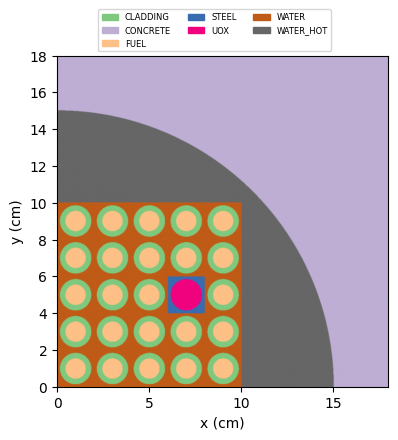

In [10]:
frame = tripoli5.geoplotter.Frame.fromMinMax(
    "XY", altitude=0, u_min=0, u_max=18, v_min=0, v_max=18
)
_ = plotter.plot(frame=frame, color_map="Accent", resolution=50)

Alternatively, one can select a specific color for a given material by providing a dictionnary associating the material name to the color. Note that the dictionnary does not need to list all materials; if a material is not present in the dictionnary a color is automatically associated using the color map.

Reusing the colormap above, we will set the water color to "darkblue" and the fuel color to "darkred" but all other materials are sampled from the "Accent" color map.

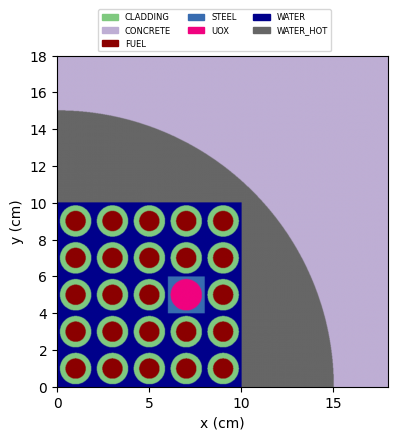

In [11]:
_ = plotter.plot(
    frame=frame,
    color_map="Accent",
    resolution=50,
    mapping_colors={
        "WATER": "darkblue",
        "FUEL": "darkred",
    },
)

### Interrogating the geometry

The `plot` function relies on the geometry navigator from TRIPOLI-5 which is the exact navigation system particles use in the transport process.  
There are several ways of building the pixel array using the relation between coordinates of the center of a pixel and the associated material: 
- directly ask for the material at a point location
- traverse the geometry using a ray-tracing algorithm (this is the default mode)

These two options allow interrogating / plotting the geometry in different ways which can be extremely useful to detect errors in the geometry (such as olverlapping volumes, for instance).  

Also, it is possible to plot the volume boundaries on top (or instead) of coloring the volume based on its content.

All these options are handled using the `mode` option.

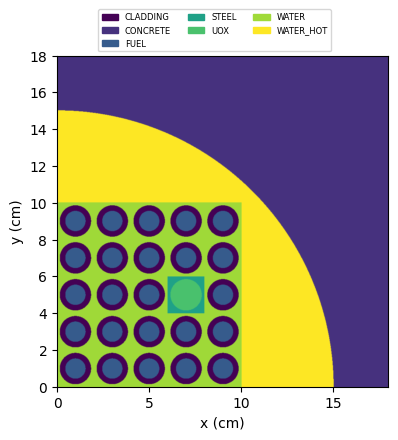

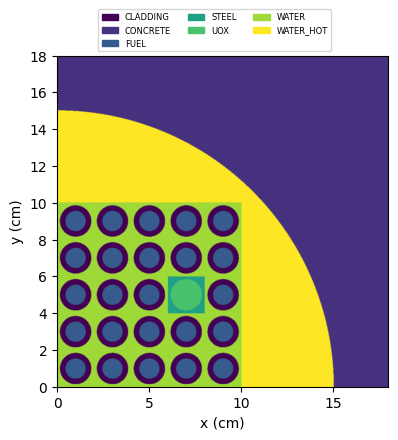

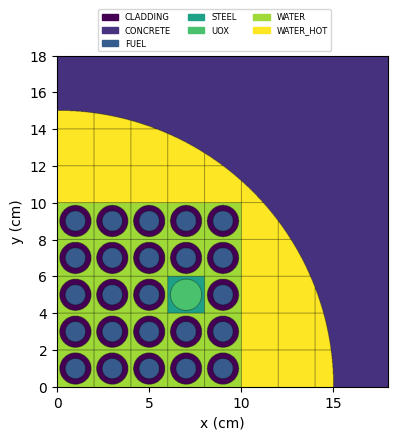

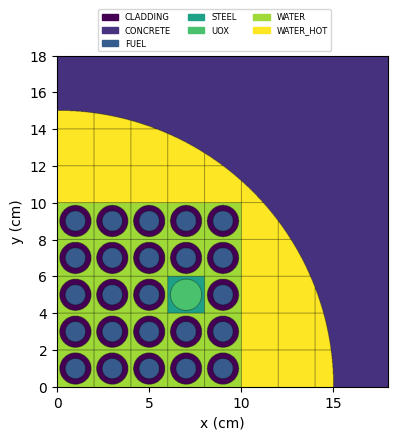

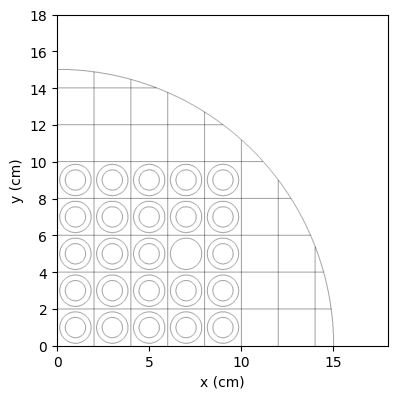

In [12]:
_ = plotter.plot(frame=frame, resolution=50, mode="point")
_ = plotter.plot(frame=frame, resolution=50, mode="track")
_ = plotter.plot(frame=frame, resolution=50, mode="point-wireframe")
_ = plotter.plot(frame=frame, resolution=50, mode="track-wireframe")
_ = plotter.plot(frame=frame, resolution=50, mode="wireframe")